# Positive feedback with cooperativity
Indirect or direct positive feedback that is characterized by a kinetic order > 1. A simple model is illustrated by the mechanism below. $\beta$ and v are basal and maximal synthesis rates of A. K is the equilibrium dissociation constant for the dimer to the promoter.

<img src='https://github.com/davidtgonzales/Bistability/blob/master/feedback.png?raw=true',width=250>

\begin{equation}
\frac{dA}{dt}=\beta+\frac{vA_2}{K+A_2}-2k_aA^2+2k_dA_2-k_{deg}A \\
\frac{dA_2}{dt}=2k_aA^2-2k_dA_2-k_{deg}A_2
\end{equation}

## 1 Trajectory
Dynamic profile of A and $A_2$ vs. time.

In [1]:
#Rate equations
def dA(A,A_2,t,params,dt):
    dA=(params[0]+(params[1]*A_2)/(params[2]+A_2)-2*params[3]*(A*A)+2*params[4]*A_2-params[5]*A)*dt
    return dA

def dA_2(A,A_2,t,params,dt):
    dA_2=(2*params[3]*A*A-2*params[4]*A_2-params[5]*A_2)*dt
    return dA_2

In [2]:
#Trajectory function
def trajectory(params,dt,init,t):
    import pandas as pd
    run=pd.DataFrame(columns=['A','A_2','t'])
    run=run.append(pd.DataFrame(data={'A':[init[0]],'A_2':[init[1]],'t':[0]}))
    while list(run['t'])[len(run)-1]<t:
        nextA=dA(list(run['A'])[len(run)-1],list(run['A_2'])[len(run)-1],list(run['t'])[len(run)-1],params,dt)+list(run['A'])[len(run)-1]
        nextA_2=dA_2(list(run['A'])[len(run)-1],list(run['A_2'])[len(run)-1],list(run['t'])[len(run)-1],params,dt)+list(run['A_2'])[len(run)-1]
        nextt=list(run['t'])[len(run)-1]+dt
        run=run.append(pd.DataFrame(data={'A':[nextA],'A_2':[nextA_2],'t':[nextt]}))
    return run

In [3]:
#Set initial values, parameters, and run trajectory
init=[0.02,0] #[Ai,A_2i]
params=[0.2,0.8,0.8,1.5,0.3,0.4] #[beta,v,K,ka,kd,kdeg]
t=20
dt=0.1
run=trajectory(params,dt,init,t)

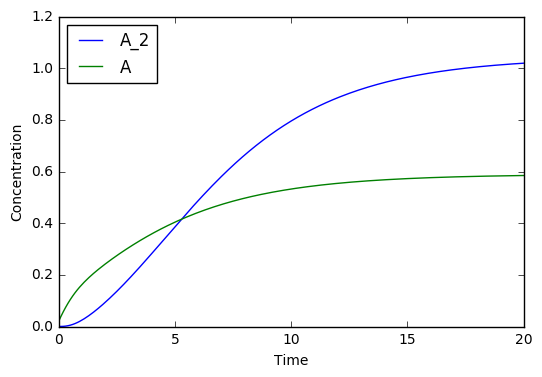

In [5]:
#Plot results
import matplotlib.pyplot as plt
plt.plot(run['t'],run['A_2'])
plt.plot(run['t'],run['A'])
plt.xlim(0,20)
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

## 2 Steady-state
Equilibrium concentrations of A and $A_2$ at varying parameters and initial values.

In [93]:
def equations(x):
    out=[(params[0]+(params[1]*x[1])/(params[2]+x[1])-2*params[3]*(x[0]*x[0])+2*params[4]*x[1]-params[5]*x[0])]
    out.append(2*params[3]*x[0]*x[0]-2*params[4]*x[1]-params[5]*x[1])
    return out

def equilibrium():
    from scipy.optimize import fsolve
    import math
    Aeq=fsolve(equations,(1,1))
    return Aeq

In [94]:
import numpy as np
A=[]
A_2=[]
ka=list(np.arange(0,2,0.01))
for i in ka:
    #params=[0.2,0.8,0.8,i,0.3,0.4] 
    params=[0.2,0.8,0.3,i,0.3,0.4] #[beta,v,K,ka,kd,kdeg]
    Aeq=equilibrium()
    A.append(Aeq[0])
    A_2.append(Aeq[1])

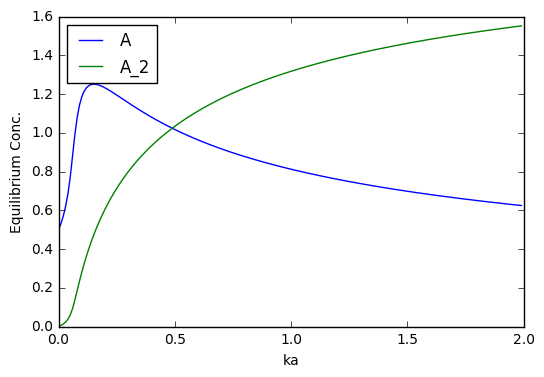

In [95]:
#Plot results
import matplotlib.pyplot as plt
import pandas as pd
out=pd.DataFrame({'A':A,'A_2':A_2,'ka':ka})
plt.plot(out['ka'],out['A'])
plt.plot(out['ka'],out['A_2'])
plt.legend(loc=0)
plt.xlim(0,2)
plt.xlabel('ka')
plt.ylabel('Equilibrium Conc.')
plt.show()

## 3 Finding bistability

In [96]:
"""Using PyCont to do path following to find a zero level set of a nonlinear
function. Example is an ellipse.

Robert Clewley, August 2008.
"""

from PyDSTool import *

# f(y) = 0 is the required form
# where f(y) = x^2 /2 + y^2 - 1
DSargs = args(name='ellipse')

# treat one of the coordinates as a parameter for PyCont to use
DSargs.pars = {'x': 0}

# the other coordinate is a 'variable'
DSargs.varspecs = {'y': 'x*x/2.+y*y-1'}

# A starting point on the ellipse, if known. Let's pretend it's a tougher
# problem and we only know a point that's close to it: (x,y) = (0, 1.1)
# PyCont will find the closest point that's actually on the curve before
# doing the path following
DSargs.ics = {'y': 1.1}

# Define an initial value problem (ODE) with f(x) as the right hand side.
# For this example, it is just a formality to present PyCont with f(x).
# In examples involving fixed points or limit cycles of dynamical systems,
# this ODE will have a practical meaning.
testODE = Vode_ODEsystem(DSargs)

# Create an instance of PyCont
P = ContClass(testODE)

# EP-C = equilibrium point curve
PCargs = args(name='test', type='EP-C')
PCargs.freepars = ['x']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 1e-2

# Declare a new curve based on the above criteria
P.newCurve(PCargs)

# Do path following in the 'forward' direction. Max points is large enough
# to ensure we go right around the ellipse (PyCont automatically stops when
# we return to the initial point - unless MaxNumPoints is reached first.)
P['test'].forward()

sol = P['test'].sol

print "There were %i points computed" % len(sol)
# solution points:
print sol

print "\nLabels for each point in sol pointset give diagnostic information about"
print "first derivative of the point along the curve ('V' entry) and the arc "
print "length parameter shows distance along the curve so far ('ds' entry)."

print "\nVelocity around curve is always 1, e.g. look at 100th point"
print "norm(Point(sol[100].labels['EP']['data'].V)) =", \
      norm(Point(sol[100].labels['EP']['data'].V))

print "... at which we have travelled distance ds =", \
      sol[100].labels['EP']['data'].ds

print "\nThis distance is equal to 100 * the max step size (0.01) which PyCont"
print "deemed sufficient for the desired accuracy."

# easy way to plot the result
P.display(curves=['test'], coords=('x','y'))

ImportError: No module named PyDSTool